# Original vs simulated counts

This notebook tests the hypothesis that the VAE isn’t adequately accounting for low read counts.

Say we have an experiment with low read depth where a set of genes have 0 expression (i.e. not detectable).
After going through the VAE shifting process, the gene counts might get compressed (i.e. very low gene counts are increased and very high gene counts are decreased) so that the new simulated counts for these originally 0-expressed genes, which should have a high error rate and therefore not found to be DE by DESeq, can be found as DE by DESeq with the artificial shift in values. If this is the case, we will need a way to re-scale values to account for the read depth differences.

In [1]:
%load_ext autoreload
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ponyo import utils
from generic_expression_patterns_modules import ranking

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)
local_dir = params["local_dir"]
dataset_name = params["dataset_name"]
project_id = params["project_id"]
col_to_rank_genes = params["rank_genes_by"]
template_filename = os.path.join(
    base_dir, dataset_name, params["processed_template_filename"]
)

# Directory containing simulated experiments
simulated_dir = os.path.join(local_dir, "pseudo_experiment")
run = 4

In [3]:
# Read template experiment
template = pd.read_csv(template_filename, sep="\t", index_col=0, header=0)

In [4]:
def scatter_plot_original_vs_simulated(
    ncols,
    nrows,
    fig_width,
    fig_height,
    num_simulated,
    by_sample_or_gene,
    gene_list=None,
):
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, fig_height))
    axes = axes.ravel()

    if by_sample_or_gene == "sample":
        for i in range(num_simulated):
            # Get simulated filename
            simulated_filename = os.path.join(
                simulated_dir, f"selected_simulated_data_{project_id}_{i}_processed.txt"
            )

            # Read simulated experiment
            simulated = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

            # Create dataframe with columns
            # 1. Sample id
            # 2. Total counts across genes original (template)
            # 3. Total counts across genes after VAE (simulated)
            # Note the total counts is using all genes
            template_sample_counts = template.sum(axis=1)
            simulated_sample_counts = simulated.sum(axis=1)

            sample_counts = template_sample_counts.to_frame("Original counts").merge(
                simulated_sample_counts.to_frame("Simulated counts"),
                left_index=True,
                right_index=True,
            )

            # Plot per sample
            f = sns.scatterplot(
                data=sample_counts,
                x="Simulated counts",
                y="Original counts",
                alpha=0.8,
                ax=axes[i],
            )

            min_ = sample_counts.min().min()
            max_ = sample_counts.max().max()
            f.plot([min_, max_], [min_, max_], "k--")

            axes[i].set_ylabel("")
            axes[i].set_xlabel("")

        fig.text(
            0.5,
            0.0,
            "Simulated counts (after VAE)",
            ha="center",
            fontsize=14,
            fontname="Verdana",
        )
        fig.text(
            0.08,
            0.5,
            "Actual counts",
            va="center",
            rotation="vertical",
            fontsize=14,
            fontname="Verdana",
        )
        fig.suptitle(
            "Actual vs simulated counts per sample",
            fontsize=16,
            fontname="Verdana",
        )
    elif by_sample_or_gene == "gene":
        for i in range(num_simulated):
            # Get simulated filename
            simulated_filename = os.path.join(
                simulated_dir, f"selected_simulated_data_{project_id}_{i}_processed.txt"
            )

            # Read simulated experiment
            simulated = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

            # Create dataframe with columns
            # 1. Gene id
            # 2. Total counts across samples original (template)
            # 3. Total counts across samples after VAE (simulated)
            if gene_list is not None:
                template_gene_counts = template[gene_list].sum()
                simulated_gene_counts = simulated[gene_list].sum()
            else:
                template_gene_counts = template.sum()
                simulated_gene_counts = simulated.sum()

            gene_counts = template_gene_counts.to_frame("Original counts").merge(
                simulated_gene_counts.to_frame("Simulated counts"),
                left_index=True,
                right_index=True,
            )

            # Plot per sample
            g = sns.scatterplot(
                data=gene_counts,
                x="Simulated counts",
                y="Original counts",
                alpha=0.3,
                ax=axes[i],
            )

            # Note:
            # Attemplated to get hexbin plotting to take a look at the
            # density of points since they are piled on top of each other
            # But only seeing one color, not sure what the issue is here.
            # axes[i].hexbin(x=gene_counts["Simulated counts"],
            #               y=gene_counts["Original counts"],
            #               gridsize=100
            #              )
            # axes[i].set_ylim([0, 0.1e7])
            # axes[i].set_xlim([0, 0.1e7])

            min_ = gene_counts.min().min()
            max_ = gene_counts.max().max()
            g.plot([min_, max_], [min_, max_], "k--")
            g.plot([0, 0.1e7], [0, 0.1e7], "k--")
            axes[i].set_ylabel("")
            axes[i].set_xlabel("")

        fig.text(
            0.5,
            0.0,
            "Simulated counts (after VAE)",
            ha="center",
            fontsize=14,
            fontname="Verdana",
        )
        fig.text(
            0.08,
            0.5,
            "Actual counts",
            va="center",
            rotation="vertical",
            fontsize=14,
            fontname="Verdana",
        )
        fig.suptitle(
            "Actual vs simulated counts per gene",
            fontsize=16,
            fontname="Verdana",
        )

## Examine per sample total counts

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


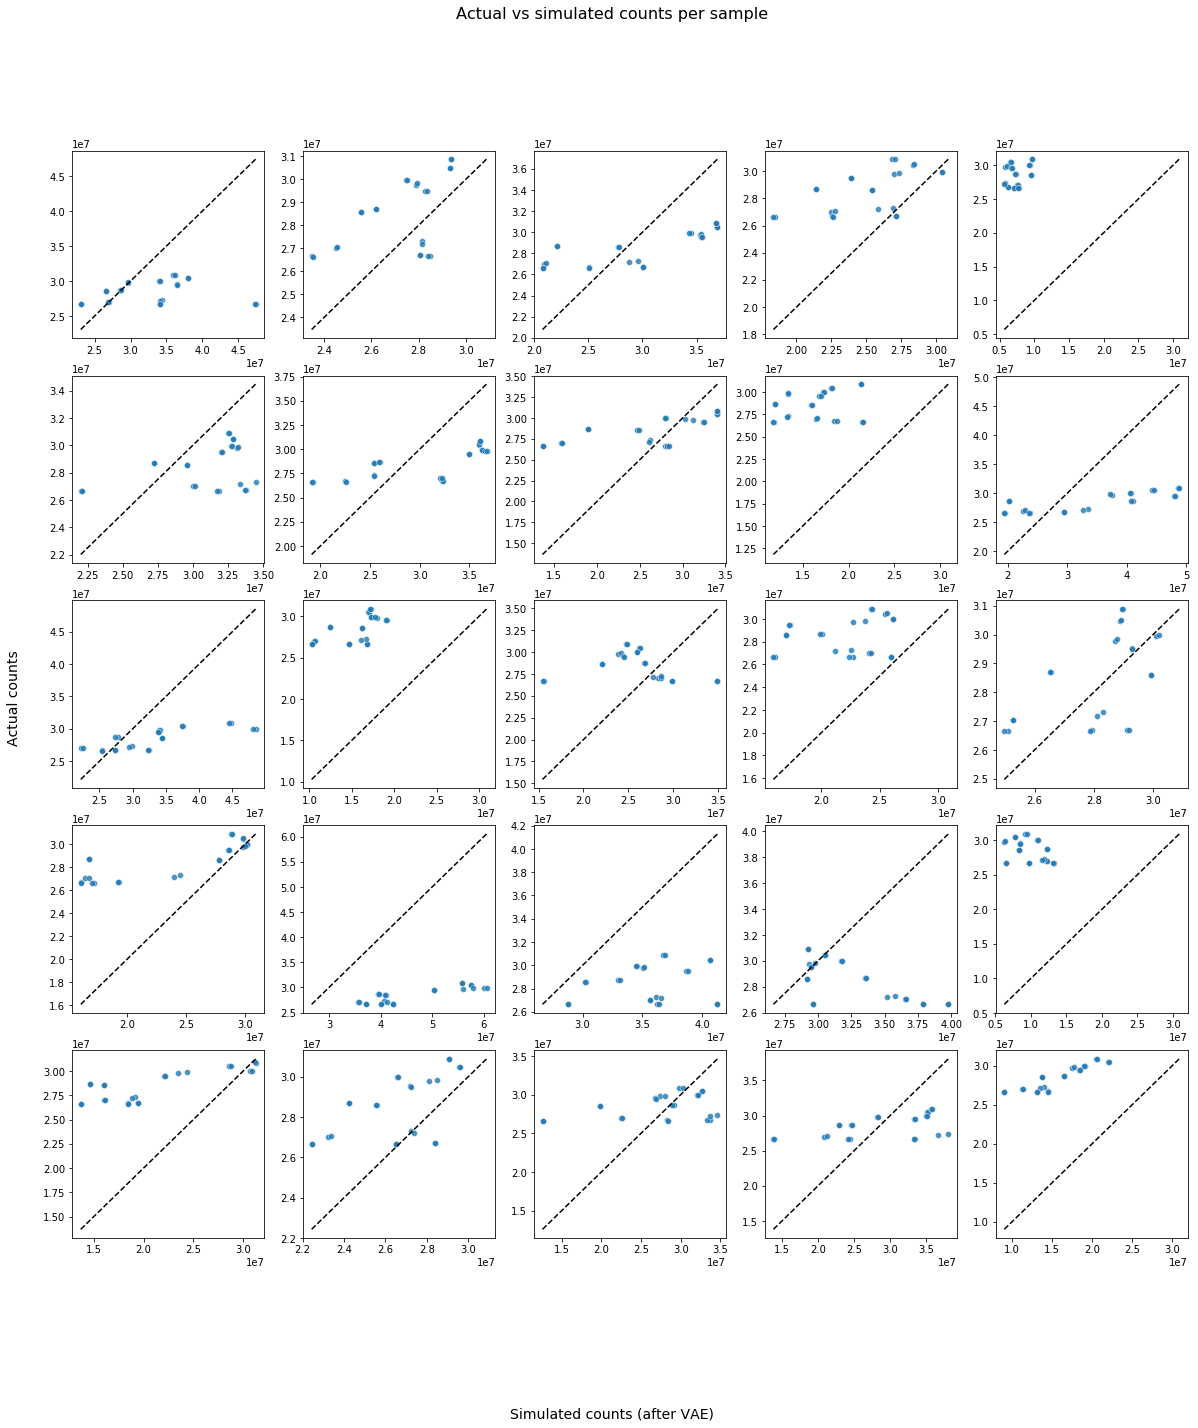

In [5]:
# Compare per sample
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="sample",
)

**Observations:**
* For about half of the cases, here is a horizontal trend that indicates that the variance in the actual total counts is lower compared to the simulated total counts. In other words the sequencing coverage of the actual experiment is consistent while the sequencing coverage of the simulated samples is variable.
* Overall, there are cases where most/all samples have a lower total read count in the simulated experiments compared to the actual experiment (when samples are all on one side of the diagonal). There are also cases where some samples have increased counts in the simulated experiment and some have decreased counts in the simulated experiment (i.e. when sample cross the diagonal).

* Ideally I would expect that the sequencing coverage of samples within a simulated experiment to be very tight (so not much spread horizontally. I would also expected that the sequencing coverage of the simulated experiment to be similar to the actual experiment, so the samples should cluster along the diagonal.

**Takeaway:**

 After going through the VAE shifting process, some samples seem to have increased or decreased sequencing coverage/depth (i.e. total read count) compared to the actual sample. DESeq will scale count estimates and give a higher prob of error for genes with a low sequence coverage/depth. If different simulated samples have different sequencing depth, then a gene can be found to be artificially DE due to the differences in sequencing coverage between samples as opposed to the condition tested.

To correct for this we can try to re-scale the decoded counts per sample so that the sum of the simulated counts is equal to the sum of the actual total counts.

Our expectation is that once we correct the simulated samples to have the same sequencing coverage as the actual samples, some of the DE genes in the simulated experiment will go away and we believe those are the ones that were specific to RNA-seq.

## Examine per sample counts for subsets of genes

In [6]:
# Load gene_summary_filename
gene_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_gene_summary_{project_id}.tsv"
)

summary_gene_ranks = pd.read_csv(gene_summary_filename, sep="\t", index_col=0, header=0)

r = 0.1851597404594152
p = 3.711325673092676e-132
ci_low = 0.17049247251817573
ci_high = 0.19960109794209907


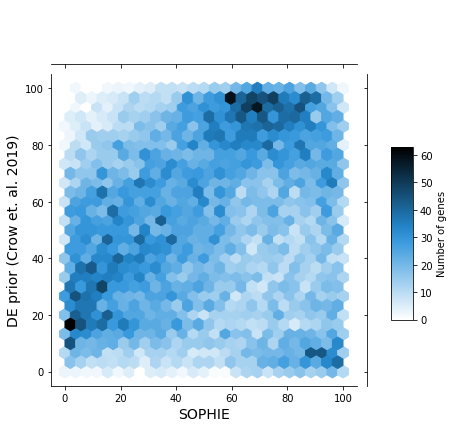

In [7]:
# Get generic genes identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]
ref_gene_col = params["reference_gene_name_col"]
ref_rank_col = params["reference_rank_col"]

figure_filename = f"gene_ranking_{col_to_rank_genes}_tmp.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks,
    DE_prior_filename,
    ref_gene_col,
    ref_rank_col,
    figure_filename,
)

In [8]:
# Get uncorrelated gene ids
uncorrelated_ranking = shared_ranking[
    (shared_ranking["Percentile (simulated)"] > 80)
    & (shared_ranking["DE_Prior_Rank"] < 20)
]

uncorrelated_genes = uncorrelated_ranking["Gene_Name"]
print(len(uncorrelated_genes))

791


In [9]:
# Get correlated gene ids
correlated_ranking = shared_ranking[
    (shared_ranking["Percentile (simulated)"] > 80)
    & (shared_ranking["DE_Prior_Rank"] > 80)
]

correlated_genes = correlated_ranking["Gene_Name"]
print(len(correlated_genes))

900


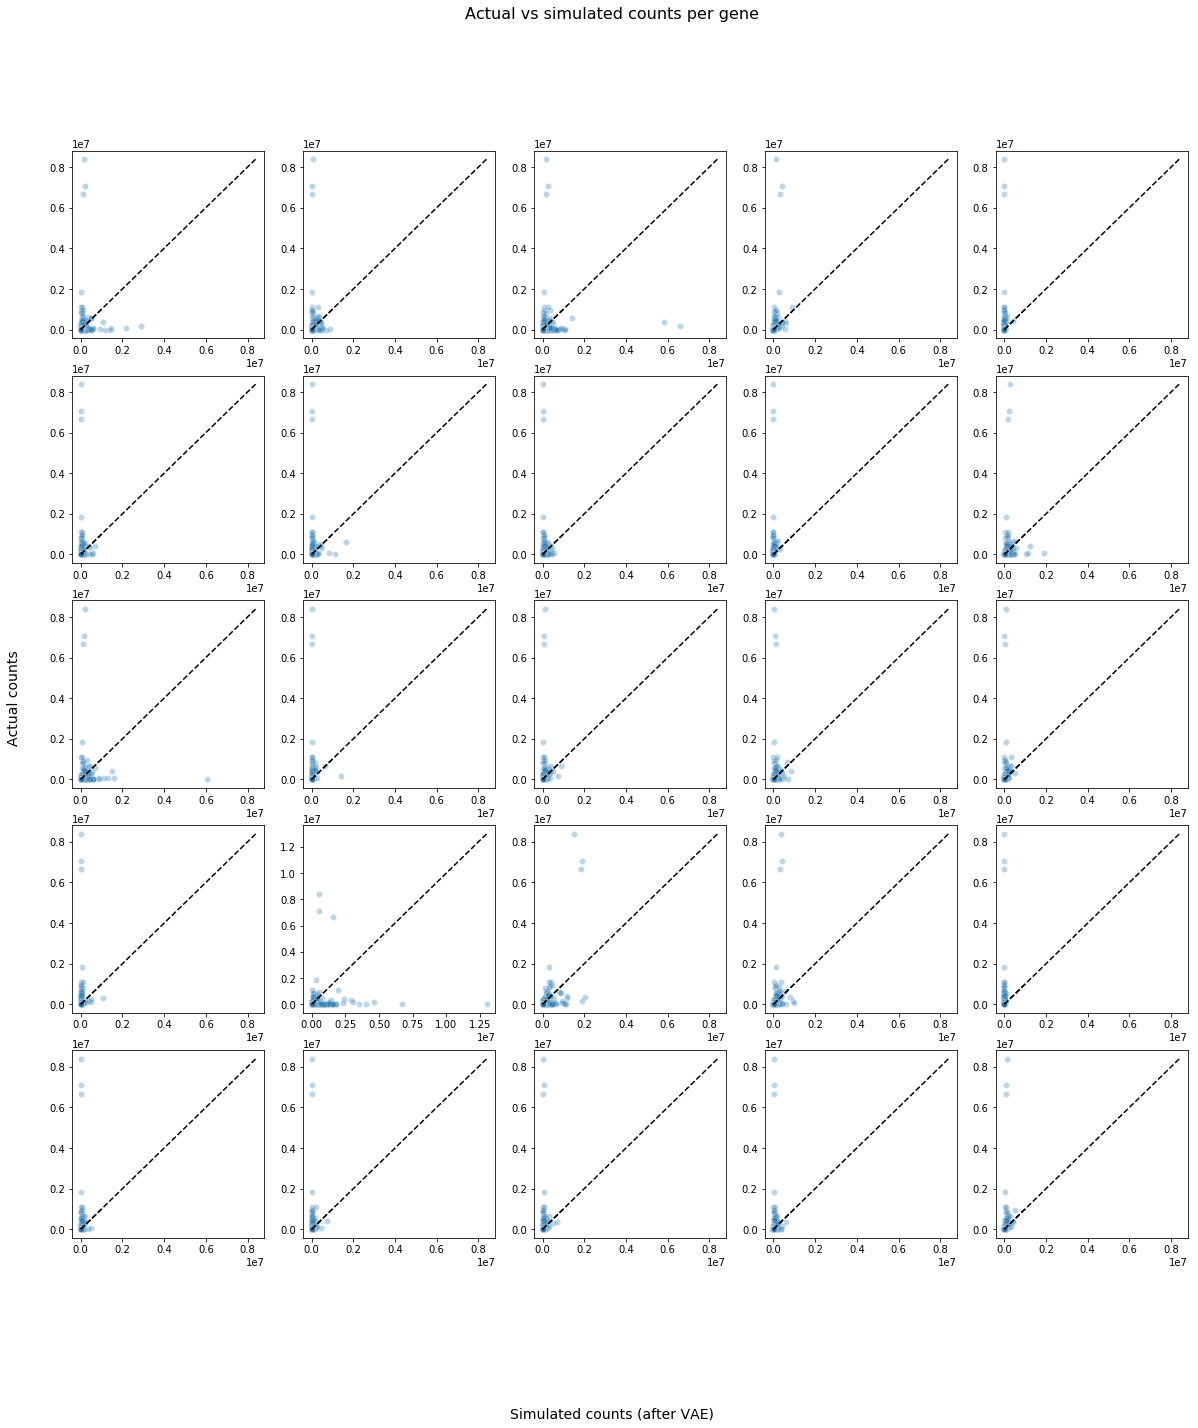

In [10]:
# Compare per gene for RNA-seq/array generic genes
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="gene",
    gene_list=correlated_genes,
)

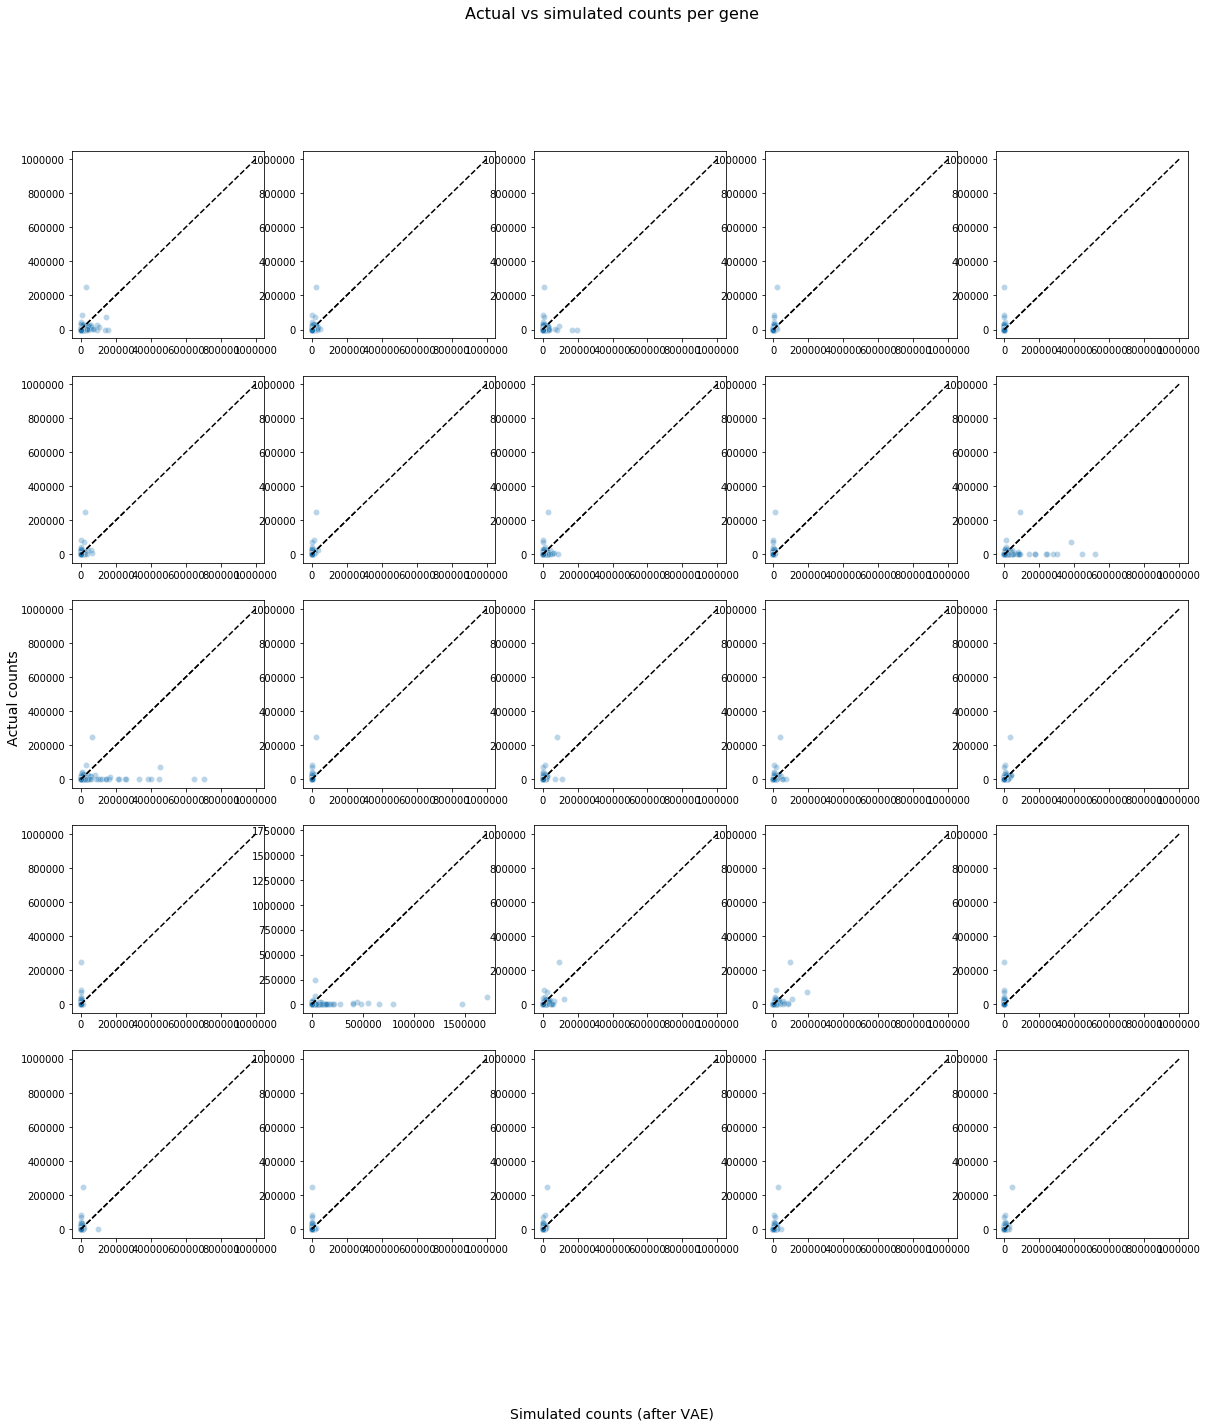

In [11]:
# Compare per sample for RNA-seq only generic genes
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="gene",
    gene_list=uncorrelated_genes,
)

## Examine per gene

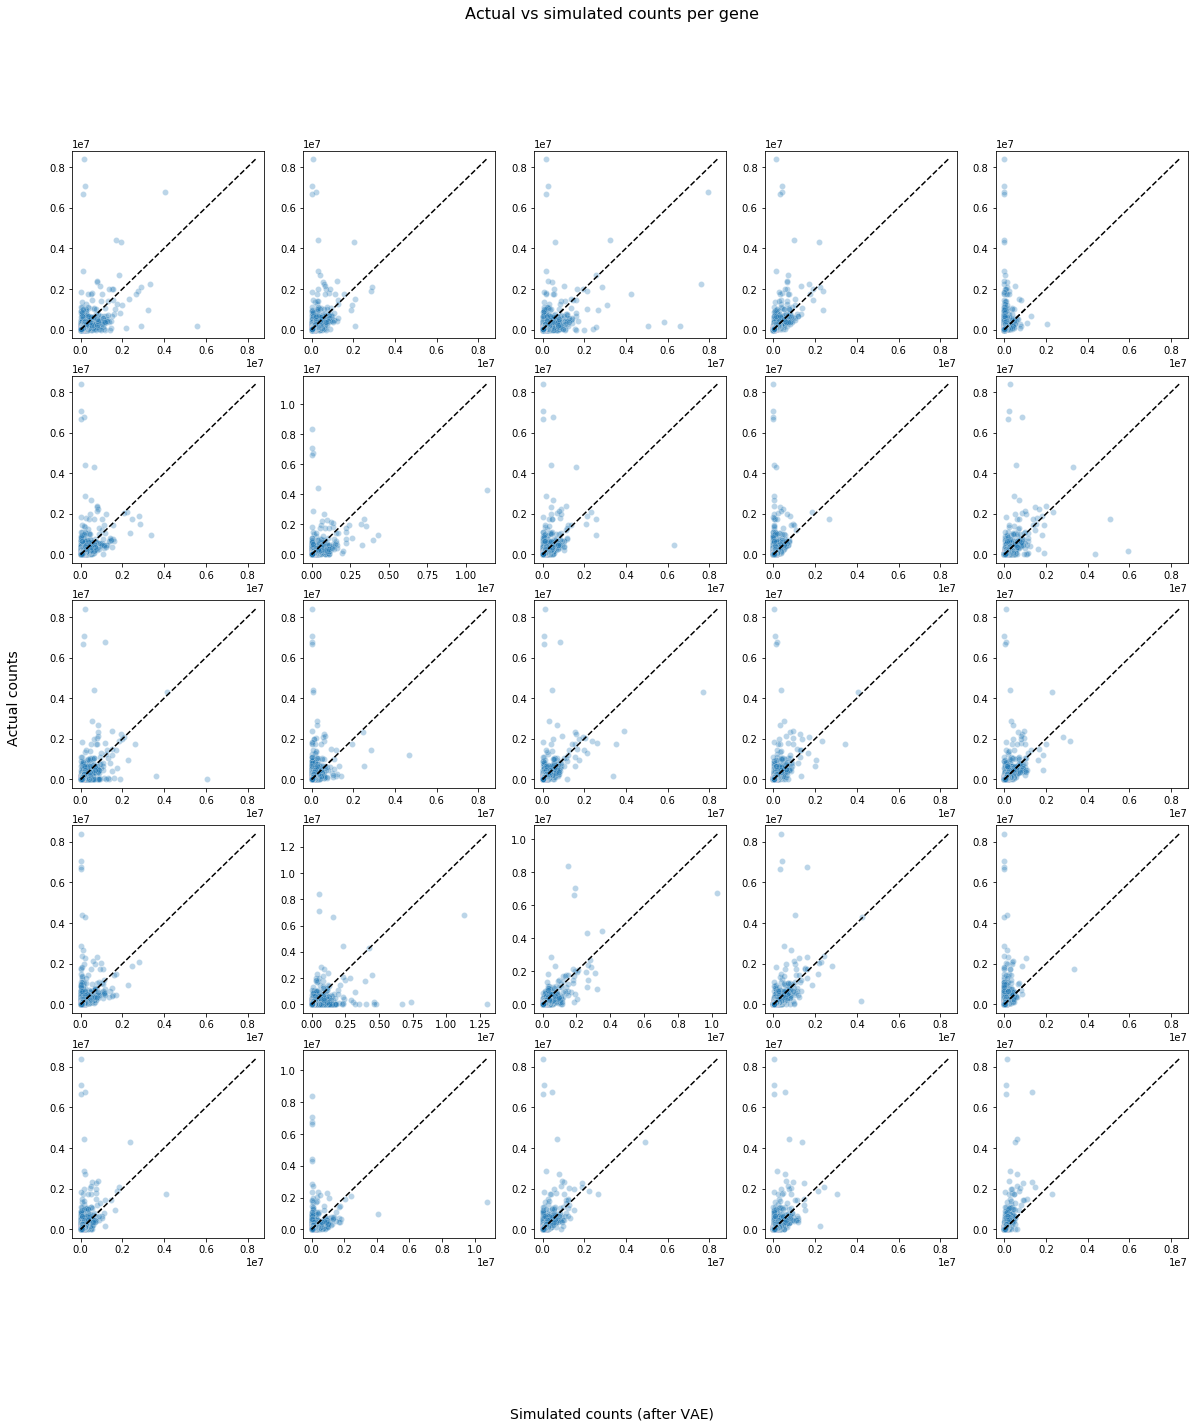

In [12]:
# Compare per gene
scatter_plot_original_vs_simulated(
    ncols=5,
    nrows=5,
    fig_width=20,
    fig_height=20,
    num_simulated=25,
    by_sample_or_gene="gene",
)

**Observations:**
* Since simulations are intended to produce different experiments, we don't expect the gene counts (activity) to be consistent between the actual vs simulated experiment which is what we see.

* Some genes that have high actual counts are reduced or increased in the simulated experiment